# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path

# Reading Train Dataset Files

In [2]:
# For reproducibility
np.random.seed(1237)
 
# Source file directory
path_train = "C://Users//hp-pc//Documents//Celebal Work//20news-bydate-train"
 
files_train = skds.load_files(path_train,load_content=False)
 
label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames
 
data_tags = ["filename","category","news"]
data_list = []
 
# Read and add data from file to a list
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text(encoding='latin1')))
    i += 1
 
# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

In [3]:
data

,filename,category,news
0,C://Users//hp-pc//Documents//Celebal Work//20n...,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,C://Users//hp-pc//Documents//Celebal Work//20n...,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,C://Users//hp-pc//Documents//Celebal Work//20n...,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,C://Users//hp-pc//Documents//Celebal Work//20n...,comp.sys.mac.hardware,From: ()\nSubject: Re: Quadra SCSI Problems??...
4,C://Users//hp-pc//Documents//Celebal Work//20n...,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...
...,...,...,...
11309,C://Users//hp-pc//Documents//Celebal Work//20n...,rec.motorcycles,From: rbemben@timewarp.prime.com (Rich Bemben)...
11310,C://Users//hp-pc//Documents//Celebal Work//20n...,comp.windows.x,From: stevedav@netcom.com (Steve Davidson)\nSu...
11311,C://Users//hp-pc//Documents//Celebal Work//20n...,talk.politics.guns,From: 0005111312@mcimail.com (Peter Nesbitt)\n...
11312,C://Users//hp-pc//Documents//Celebal Work//20n...,talk.politics.misc,From: eck@panix.com (Mark Eckenwiler)\nSubject...


# Splitting 80% Train Data as training data and 20% for validation

In [4]:
# lets take 80% data as training and remaining 20% for validation
train_size = int(len(data) * .8)
 
train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]
 
validation_test_posts = data['news'][train_size:]
validation_test_tags = data['category'][train_size:]
validation_test_files_names = data['filename'][train_size:]

# Tokenizing and Applying TF-IDF

In [5]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)
 
x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
validation_x_test = tokenizer.texts_to_matrix(validation_test_posts, mode='tfidf')
 
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
validation_y_test = encoder.transform(validation_test_tags)

In [6]:
train_posts

0       From: cubbie@garnet.berkeley.edu (            ...
1       From: gnelson@pion.rutgers.edu (Gregory Nelson...
2       From: crypt-comments@math.ncsu.edu\nSubject: C...
3       From:  ()\nSubject: Re: Quadra SCSI Problems??...
4       From: keith@cco.caltech.edu (Keith Allan Schne...
                              ...                        
9046    From: awesley@vela.acs.oakland.edu (awesley)\n...
9047    From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
9048    From: inoue@crd.yokogawa.co.jp (Inoue Takeshi)...
9049    From: rvloon@cv.ruu.NL (Ronald van Loon)\nSubj...
9050    From: bmdelane@midway.uchicago.edu (brian mann...
Name: news, Length: 9051, dtype: object

In [7]:
x_train

array([[0.        , 1.89863301, 1.2686438 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.59386534, 1.95520345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.66933568, 2.82673079, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.90730397, 2.99392812, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.51333056, 2.95549501, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.14345099, 0.74928146, ..., 0.        , 0.        ,
        0.        ]])

# Model Building

In [8]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(validation_x_test, validation_y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1

# Training Accuracy = 99.73% , Validation Accuracy = 91.0%

In [9]:
encoder.classes_ 

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')

# Reading Test Dataset Files

In [10]:
# Source file directory
path_test = "C://Users//hp-pc//Documents//Celebal Work//20news-bydate-test"
 
files_test = skds.load_files(path_test,load_content=False)
 
label_index = files_test.target
label_names = files_test.target_names
labelled_files = files_test.filenames
 
data_tags = ["filename","category","news"]
data_list = []
 
# Read and add data from file to a list
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text(encoding='latin1')))
    i += 1
    
# We have testing data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

In [11]:
data

,filename,category,news
0,C://Users//hp-pc//Documents//Celebal Work//20n...,rec.sport.hockey,From: stimpy@dev-null.phys.psu.edu (Gregory Na...
1,C://Users//hp-pc//Documents//Celebal Work//20n...,talk.politics.guns,From: kennejs@a.cs.okstate.edu (KENNEDY JAMES ...
2,C://Users//hp-pc//Documents//Celebal Work//20n...,sci.space,From: perky@acs.bu.edu (Melissa Sherrin)\nSubj...
3,C://Users//hp-pc//Documents//Celebal Work//20n...,talk.politics.misc,From: evansmp@uhura.aston.ac.uk (Mark Evans)\n...
4,C://Users//hp-pc//Documents//Celebal Work//20n...,comp.windows.x,From: sxs@extol.Convergent.Com (S. Sridhar)\nS...
...,...,...,...
7527,C://Users//hp-pc//Documents//Celebal Work//20n...,sci.electronics,From: fennell@well.sf.ca.us (Michael Daniel Fe...
7528,C://Users//hp-pc//Documents//Celebal Work//20n...,rec.motorcycles,From: tony@morgan.demon.co.uk (Tony Kidson)\nS...
7529,C://Users//hp-pc//Documents//Celebal Work//20n...,comp.sys.mac.hardware,From: sadams@eis.calstate.edu (Steven Adams)\n...
7530,C://Users//hp-pc//Documents//Celebal Work//20n...,misc.forsale,From: jtobias@cs.tamu.edu (Jason T Tobias)\nSu...


In [12]:
test_posts = data['news'][:]
test_tags = data['category'][:]
test_files_names = data['filename'][:]

In [13]:
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

In [14]:
x_test.shape

(7532, 15000)

In [15]:
test_tags.shape

(7532,)

In [16]:
print(len(test_tags))

7532


# Topics/Labels

In [17]:
labels = np.array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x',
 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
 'talk.politics.misc', 'talk.religion.misc'])

In [18]:
prediction = model.predict(np.array(x_test))
y_pred = np.argmax(prediction, axis=1)
acc = (labels[y_pred]==test_tags).mean()
print("Test Accuracy:", acc)

Test Accuracy: 0.8110727562400425


# Test Accuracy = 81.12 %

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_tags, labels[y_pred])

# Confusion Matrix

<AxesSubplot:>

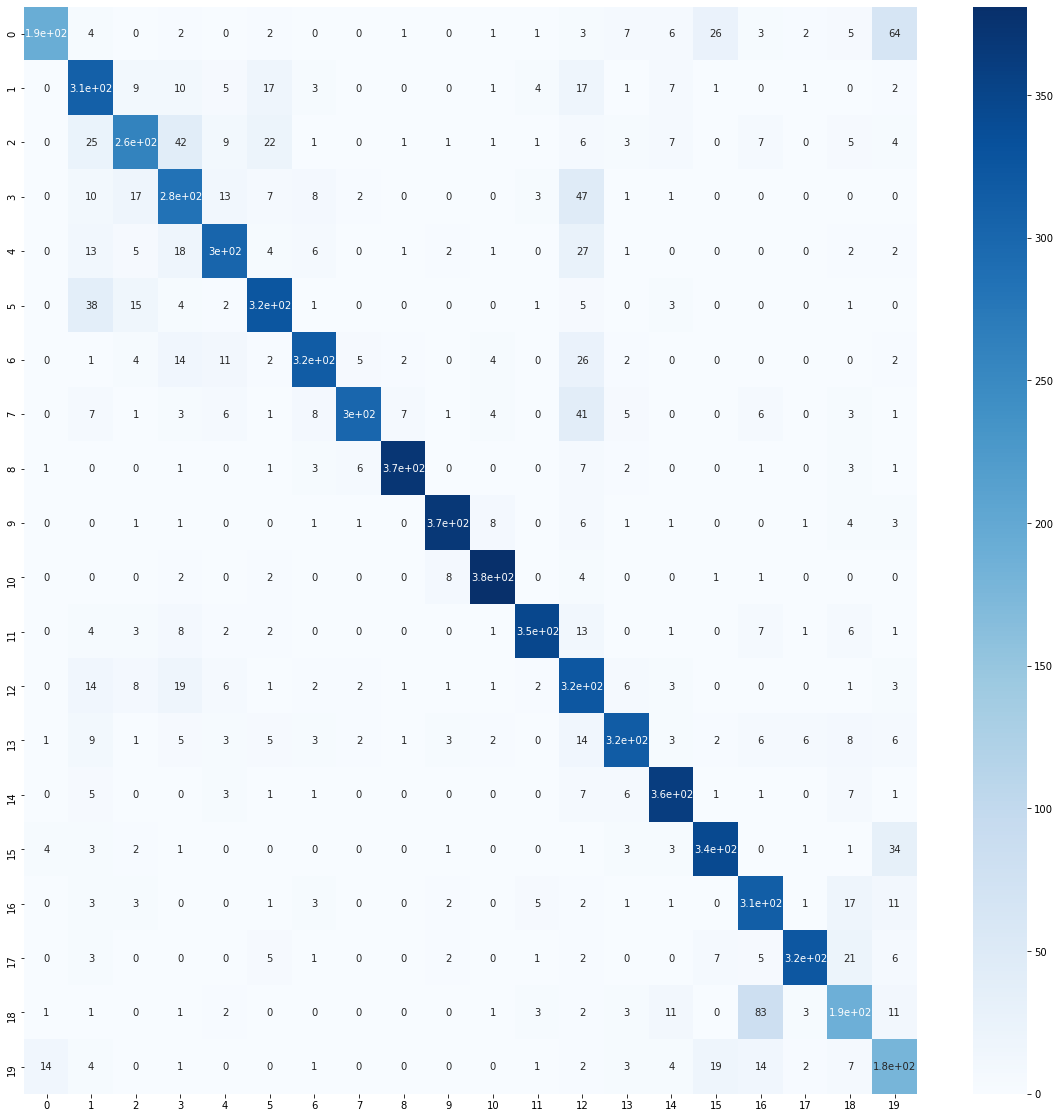

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, cmap='Blues')

# Testing Model on random paragraphs from wikipedia with same topics/labels as used on training data

In [21]:
# source: https://en.wikipedia.org/wiki/History_of_Christianity  
paragraph_1 = '''The history of Christianity concerns the Christian religion, Christian countries,\ 
    and the Church with its various denominations, from the 1st century to the present.\ 
    Christianity originated with the ministry of Jesus, a Jewish teacher and healer who \
    proclaimed the imminent kingdom of God and was crucified c. AD 30–33 in Jerusalem in \
    the Roman province of Judea. His followers believe that, according to the Gospels, he \
    was the Son of God and that he died for the forgiveness of sins and was raised from the\
    dead and exalted by God, and will return soon at the inception of God's kingdom.'''
# source: https://en.wikipedia.org/wiki/Graphics
paragraph_2 = '''Graphics (from Greek γραφικός graphikos, 'belonging to drawing') are\
               visual images or designs on some surface, such as a wall, canvas, screen,\
               paper, or stone to inform, illustrate, or entertain. In contemporary usage,\
               it includes a pictorial representation of data, as in c manufacture, in\ 
               typesetting and the graphic arts, and in educational and recreational software.\
               Images that are generated by a computer are called computer graphics.''' 
x_data = []
x_data.append(paragraph_1)
x_data.append(paragraph_2)
actual_label = ['Christianity','Graphics']
x_data_series = pd.Series(x_data)
x_tokenized = tokenizer.texts_to_matrix(x_data_series, mode='tfidf')
i=0
from tabulate import tabulate
list1 =[]
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    list1.append([actual_label[i],predicted_label])
    i += 1
print(tabulate(list1, headers=['Actual Label', 'Predicted Label'],tablefmt='fancy_grid'))  

╒════════════════╤════════════════════════╕
│ Actual Label   │ Predicted Label        │
╞════════════════╪════════════════════════╡
│ Christianity   │ soc.religion.christian │
├────────────────┼────────────────────────┤
│ Graphics       │ comp.graphics          │
╘════════════════╧════════════════════════╛
